# Principled and Practical Approaches to Emergence (PPAE) Workshop, Session 2: Practical

End-to-End SSDI Demo – from Simulation of VAR model to Optimisation Results
  
# This notebook walks through the entire SSDI workflow:

| Step | Description | Output |
|------|-------------|--------|
| 1 | **Simulate** a multivariate VAR model and convert to SS model parameters | model pickle |
| 2 | **Pre-optimisation** (many restarts) | Lp, goptp, histories |
| 3 | **Visualise** pre-opt results | composite plots |
| 4 | **Final optimisation** (clusters preoptimisation runs) and runs for clusters for multiple macroscopic dimensions *m* | Lo, dopto |
| 5 | **Visualise** optimisation results | composite plots |


# Quick Recap from the Theory Session -- What is Dynamical Independence?

Microscopic dynamics $X_t$ evolve in $mathrm{R}^N$

We seek a linear projection $M$ such that $\mathbf{Y} = M\mathbf{X} of rank $n < N$, such that considering the past of the microscopic dynamics adds nothing extra to the information of the macroscopic variable, i.e., the information flow from $\mathbf{X}$ to $\mathbf{Y}$ is minimal:



In [7]:
# 0 ▸ housekeeping -----------------------------------------------------------
import sys, os, pickle, time
import numpy as np
import matplotlib.pyplot as plt
import shutil

PROJECT_ROOT = os.path.abspath(".")          # assumes notebook in project root
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# py_ssdi imports
from py_ssdi.simulate_model                 import simulate_model
from py_ssdi.preoptimisation.preoptimise    import run_preoptimisation
from py_ssdi.optimisation.optimise          import run_optimisation
from py_ssdi.visualisation.plot_utils       import (
    plot_model_matrices,
    plot_composite_histories,
    plot_composite_goptp,
)


# A scratch folder for all notebook artefacts
NB_OUT = os.path.join(PROJECT_ROOT, "nb_results")
shutil.rmtree(NB_OUT, ignore_errors=True)
os.makedirs(NB_OUT, exist_ok=True)
print("Output directory:", NB_OUT)


Output directory: /Users/borjan/code/py_ssdi/nb_results


## 1  Simulate a VAR(9, 2) model


In [4]:
model_path = simulate_model(
    "VAR",
    n=9,
    r_var=2,
    connectivity_name="tnet9x",
    seed=42,
    spectral_norm=0.90,
    decay=1.0,
)

print("Model pickle:", model_path)

# Keep the fres grid for later
with open(model_path, "rb") as f:
    model_dict = pickle.load(f)
fres_len = model_dict["fres"]
omega    = np.linspace(0, np.pi, fres_len + 1)



Model parameters saved to: /Users/borjan/code/py_ssdi/py_ssdi/results/model_parameters/VAR_n9_r2_tnet9x.pkl

  • model_type: str  (value = VAR)
  • n: int  (value = 9)
  • r_var: int  (value = 2)
  • connectivity_name: str  (value = tnet9x)
  • seed: int  (value = 42)
  • spectral_norm: float  (value = 0.9)
  • decay: float  (value = 1.0)
  • fres: int  (value = 64)
  • ierr: float64  (value = 5.115734464059119e-13)
  • connectivity: shape = (9, 9, 2)
  • V: shape = (9, 9)
  • A_var_cor: shape = (9, 9, 2)
  • V_identity: shape = (9, 9)
  • A_var_decor: shape = (9, 9, 2)
  • A_ss: shape = (18, 18)
  • C_ss: shape = (9, 18)
  • K_ss: shape = (18, 9)
Model pickle: /Users/borjan/code/py_ssdi/py_ssdi/results/model_parameters/VAR_n9_r2_tnet9x.pkl


/Users/borjan/miniconda3/envs/py_ssdi/lib/python3.9/site-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/borjan/miniconda3/envs/py_ssdi/lib/python3.9/site-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


### Inspect simulated matrices  
Below we plot:

* connectivity mask (per lag)  
* correlated & decorrelated VAR coefficients  
* observation/state matrices of the SS representation  
* whitened residual covariance  
* Kalman gain `K_ss`

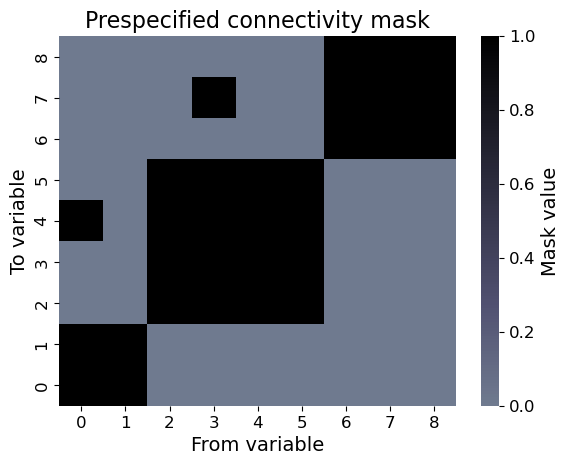

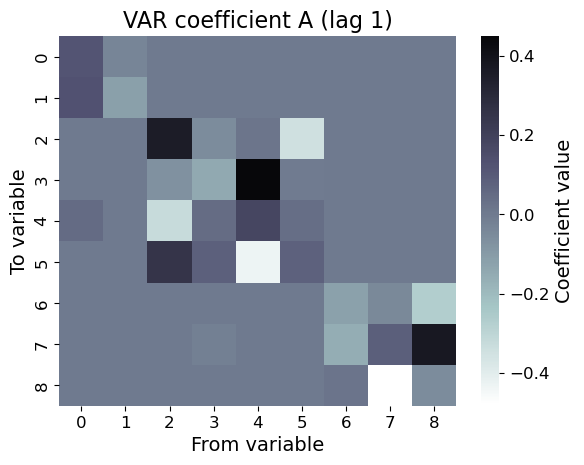

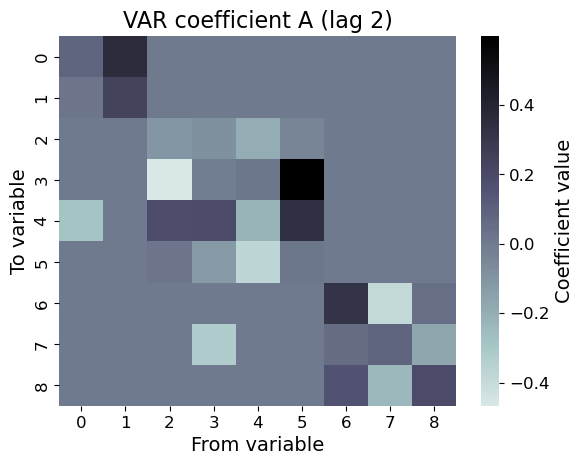

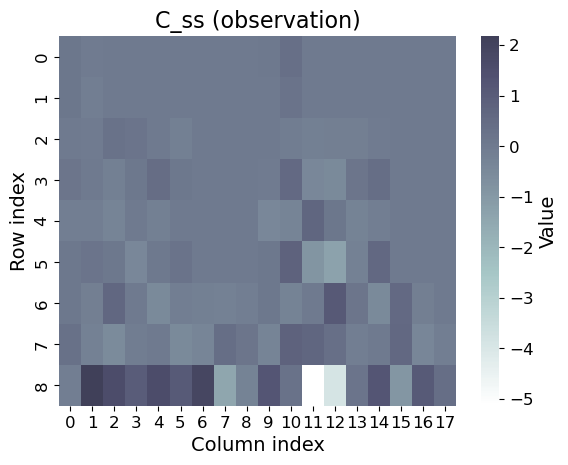

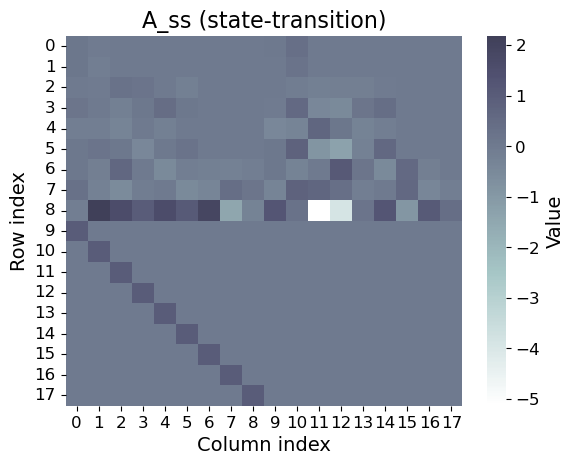

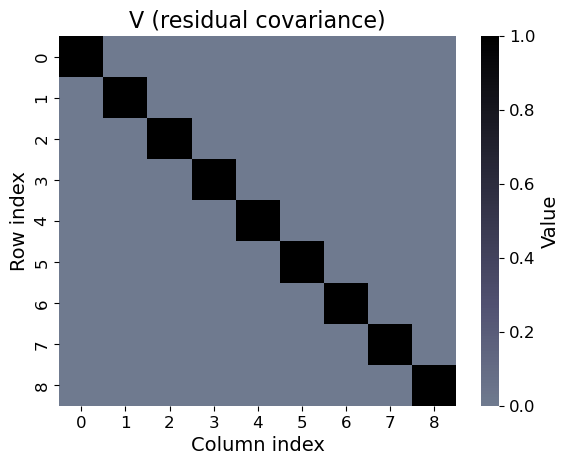

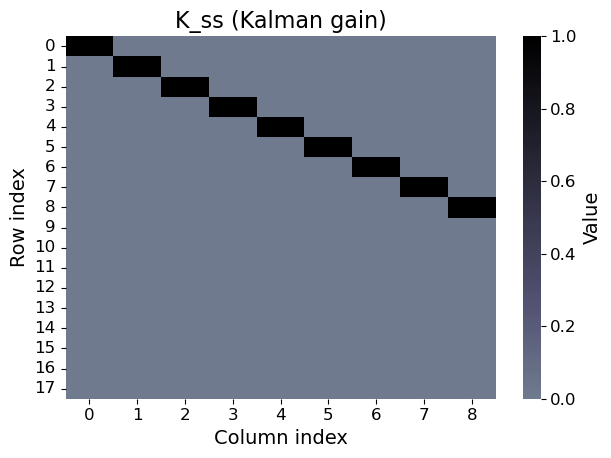

In [5]:
connectivity = model_dict["connectivity"]
A_var_cor    = model_dict["A_var_cor"]
C_ss         = model_dict["C_ss"]
A_ss         = model_dict["A_ss"]
V_id         = model_dict["V_identity"]
K_ss         = model_dict["K_ss"]

plot_model_matrices(connectivity, A_var_cor, C_ss, A_ss, V_id, K_ss)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "model_matrices.png"), dpi=150)
plt.show()


## 2  Pre-optimisation
We perform 100 random restarts for each macroscopic dimension  
*m = 2 … n−2 (= 7)*, running 10 000 gradient-descent iterations per restart.


In [6]:
preopt_path = run_preoptimisation(
    model_path,
    nrunsp=100,
    niters_p=10_000,
    init_step=0.5,
    tol=[1e-8, 1e-8, 1e-9],
    ctol=1e-3,
    compute_history=True,
    parallel=False,
)

print("Pre-opt pickle:", preopt_path)


Starting pre-optimisation for m=2
GD/ES(1) serial run   1 of 100 : dd =  9.9631e-09 : sig =  2.6496e-05 : converged(2) in 5289 iter : CPU secs =   0.81
GD/ES(1) serial run   2 of 100 : dd =  2.2728e-02 : sig =  1.3671e-04 : unconverged in 10000 iter : CPU secs =   1.52
GD/ES(1) serial run   3 of 100 : dd =  2.2728e-02 : sig =  8.2935e-07 : unconverged in 10000 iter : CPU secs =   1.53
GD/ES(1) serial run   4 of 100 : dd =  2.2728e-02 : sig =  1.9687e-04 : unconverged in 10000 iter : CPU secs =   1.52
GD/ES(1) serial run   5 of 100 : dd =  2.2780e-02 : sig =  8.4650e-04 : unconverged in 10000 iter : CPU secs =   1.52
GD/ES(1) serial run   6 of 100 : dd =  2.2728e-02 : sig =  1.5333e-05 : unconverged in 10000 iter : CPU secs =   1.56
GD/ES(1) serial run   7 of 100 : dd =  6.6940e-09 : sig =  4.5785e-05 : converged(2) in 7478 iter : CPU secs =   1.13
GD/ES(1) serial run   8 of 100 : dd =  4.9393e-09 : sig =  3.8154e-05 : converged(2) in 5747 iter : CPU secs =   0.87
GD/ES(1) serial run   

### Composite diagnostics for **each** macroscopic dimension *m*


/var/folders/yy/z6qg2k8n2h3g714cbbr9xp040000gn/T/ipykernel_19205/1628010553.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_g.show()
/var/folders/yy/z6qg2k8n2h3g714cbbr9xp040000gn/T/ipykernel_19205/1628010553.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_h.show()


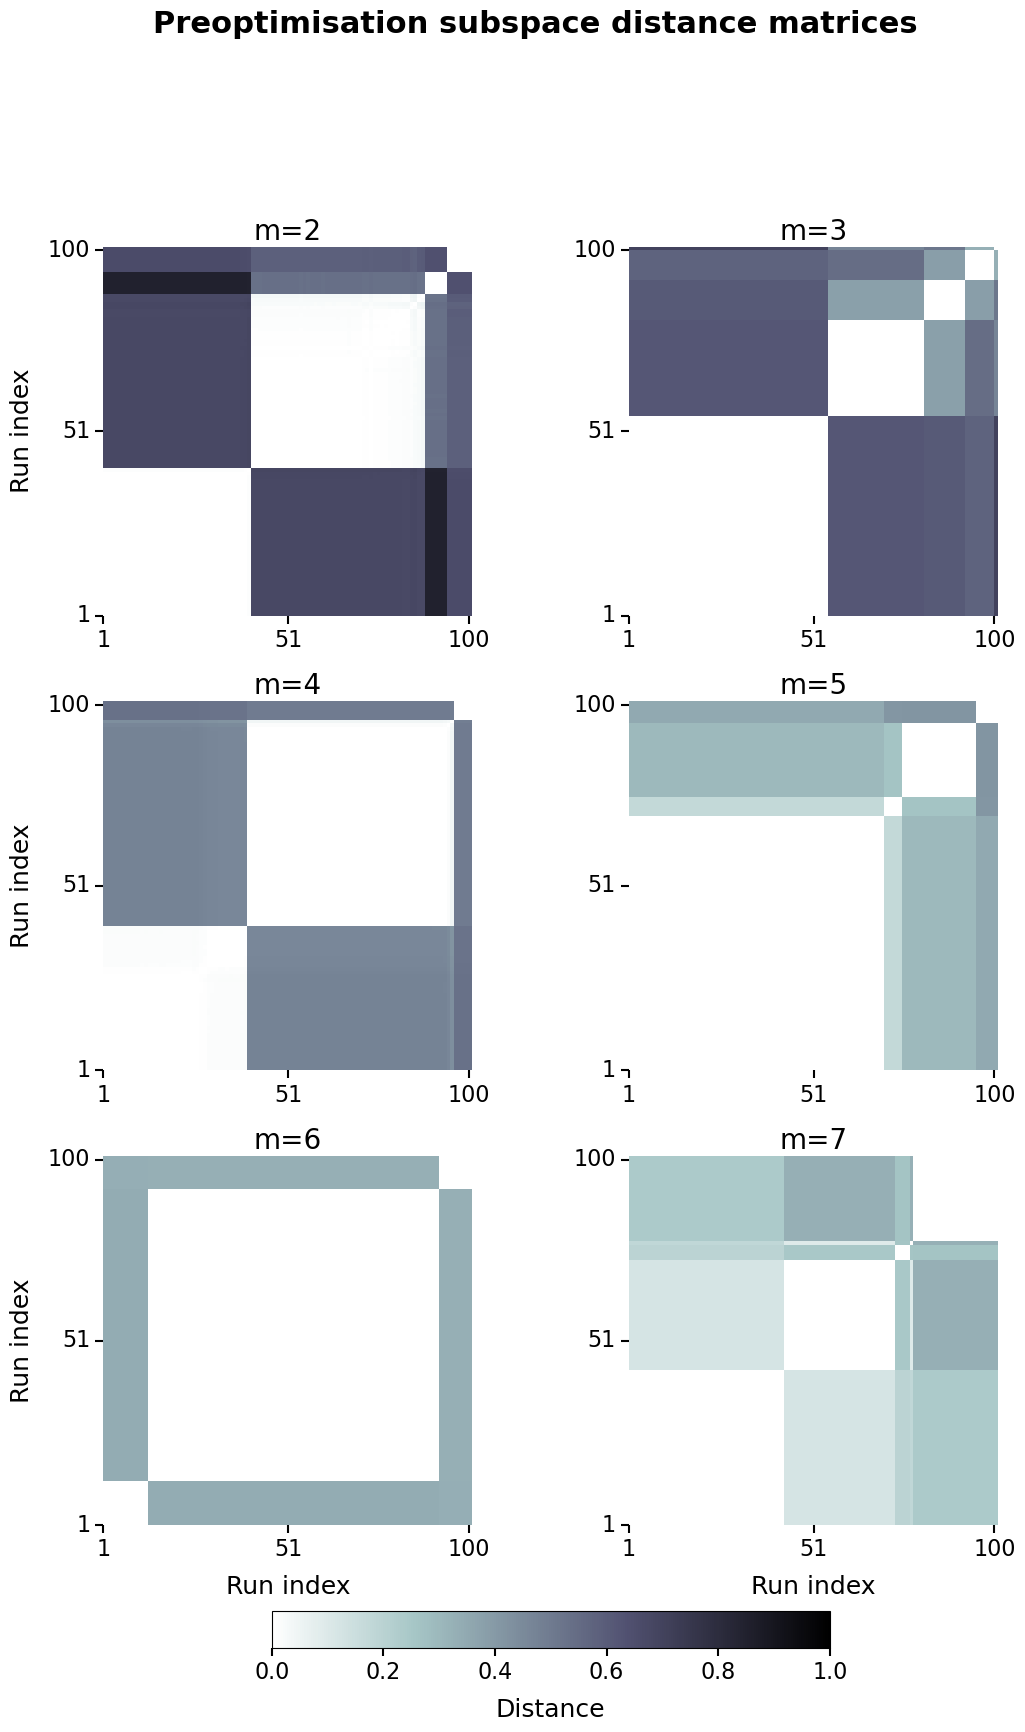

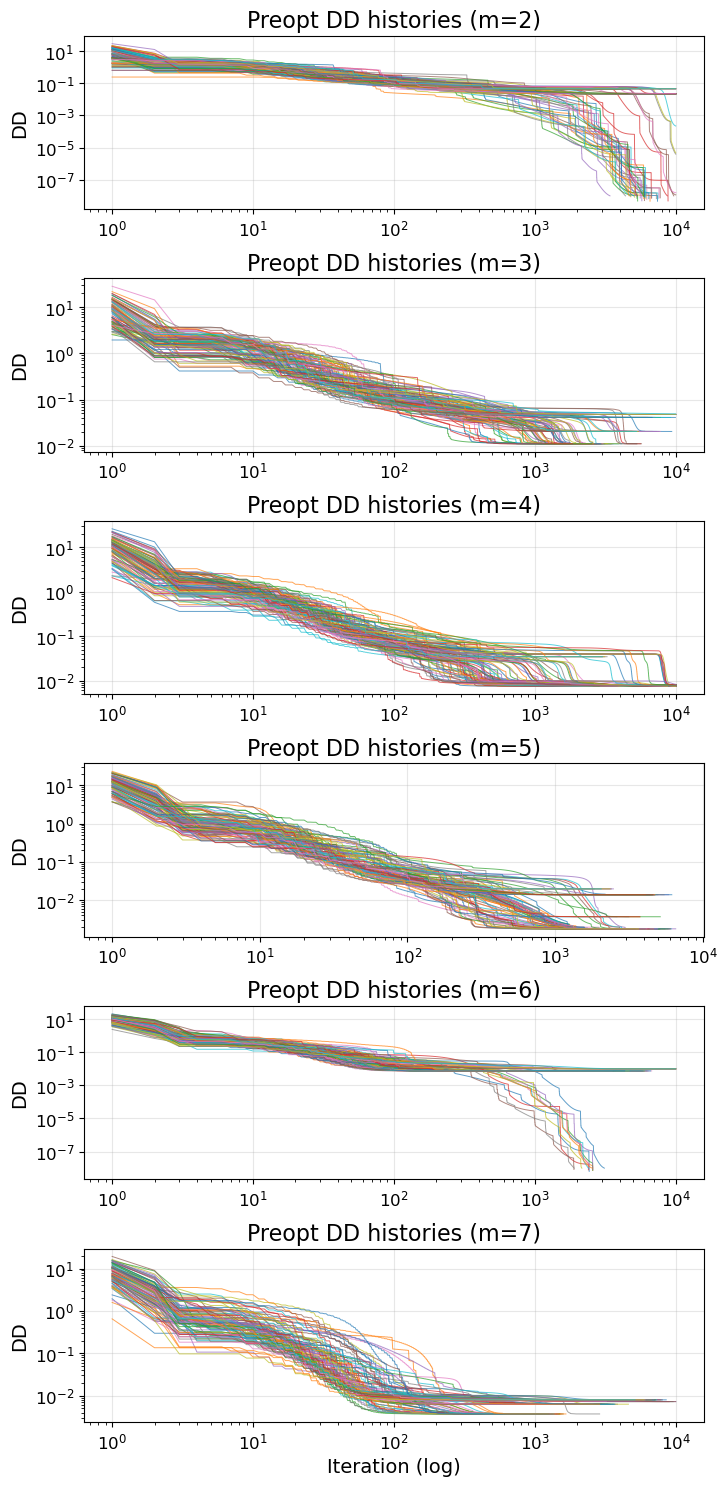

In [8]:
with open(preopt_path, "rb") as f:
    pre = pickle.load(f)
pre_results = pre["results"]

# Composite distance-matrices across all m
fig_g = plot_composite_goptp(pre_results)
fig_g.savefig(os.path.join(NB_OUT, "preopt_goptp_all.png"), dpi=200)
fig_g.show()

# Composite DD-history panels
fig_h = plot_composite_histories(pre_results)
fig_h.savefig(os.path.join(NB_OUT, "preopt_hist_all.png"), dpi=200)
fig_h.show()

## 3  Final optimisation (m = 2 … 7)
Optimise SSDI objective for every *m = 2 … 7* using **variant-1** gradient
descent (10 000 iters each).  
We reuse the frequency grid stored in the model pickle.

In [10]:
omega = np.linspace(0, np.pi, model_dict["fres"] + 1)
opt_results = {}
for mdim in range(2, 8):
    print(f"\n=== Optimising for m = {mdim} ===")
    opt_results[mdim] = run_optimisation(
        model_path      = model_path,
        preopt_path     = preopt_path,
        mdim            = mdim,
        fres            = omega,
        niters_o        = 10_000,
        init_step       = 0.1,
        tol             = 1e-10,
        ctol            = 1e-6,
        compute_history = True,
        parallel        = False,
    )



=== Optimising for m = 2 ===

Starting 92 optimization runs with 10000 max iterations each
GD/DD(2) serial run   1 of  92 : dd = -5.2008e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   2 of  92 : dd = -5.2008e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   3 of  92 : dd = -5.2002e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   4 of  92 : dd = -5.2008e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   5 of  92 : dd = -5.2001e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   6 of  92 : dd = -5.2009e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   7 of  92 : dd = -5.2007e-03 : sig = 5.0000e-02 : converged(2) in    2 iter : CPU secs =   0.00
GD/DD(2) serial run   8 of  92 : dd = -5.2009e-03 : sig = 5.0000e-02 : converged(2) in   

### Composite optimisation plots


/var/folders/yy/z6qg2k8n2h3g714cbbr9xp040000gn/T/ipykernel_19205/1681261141.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_g2.show()
/var/folders/yy/z6qg2k8n2h3g714cbbr9xp040000gn/T/ipykernel_19205/1681261141.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_h2.show()


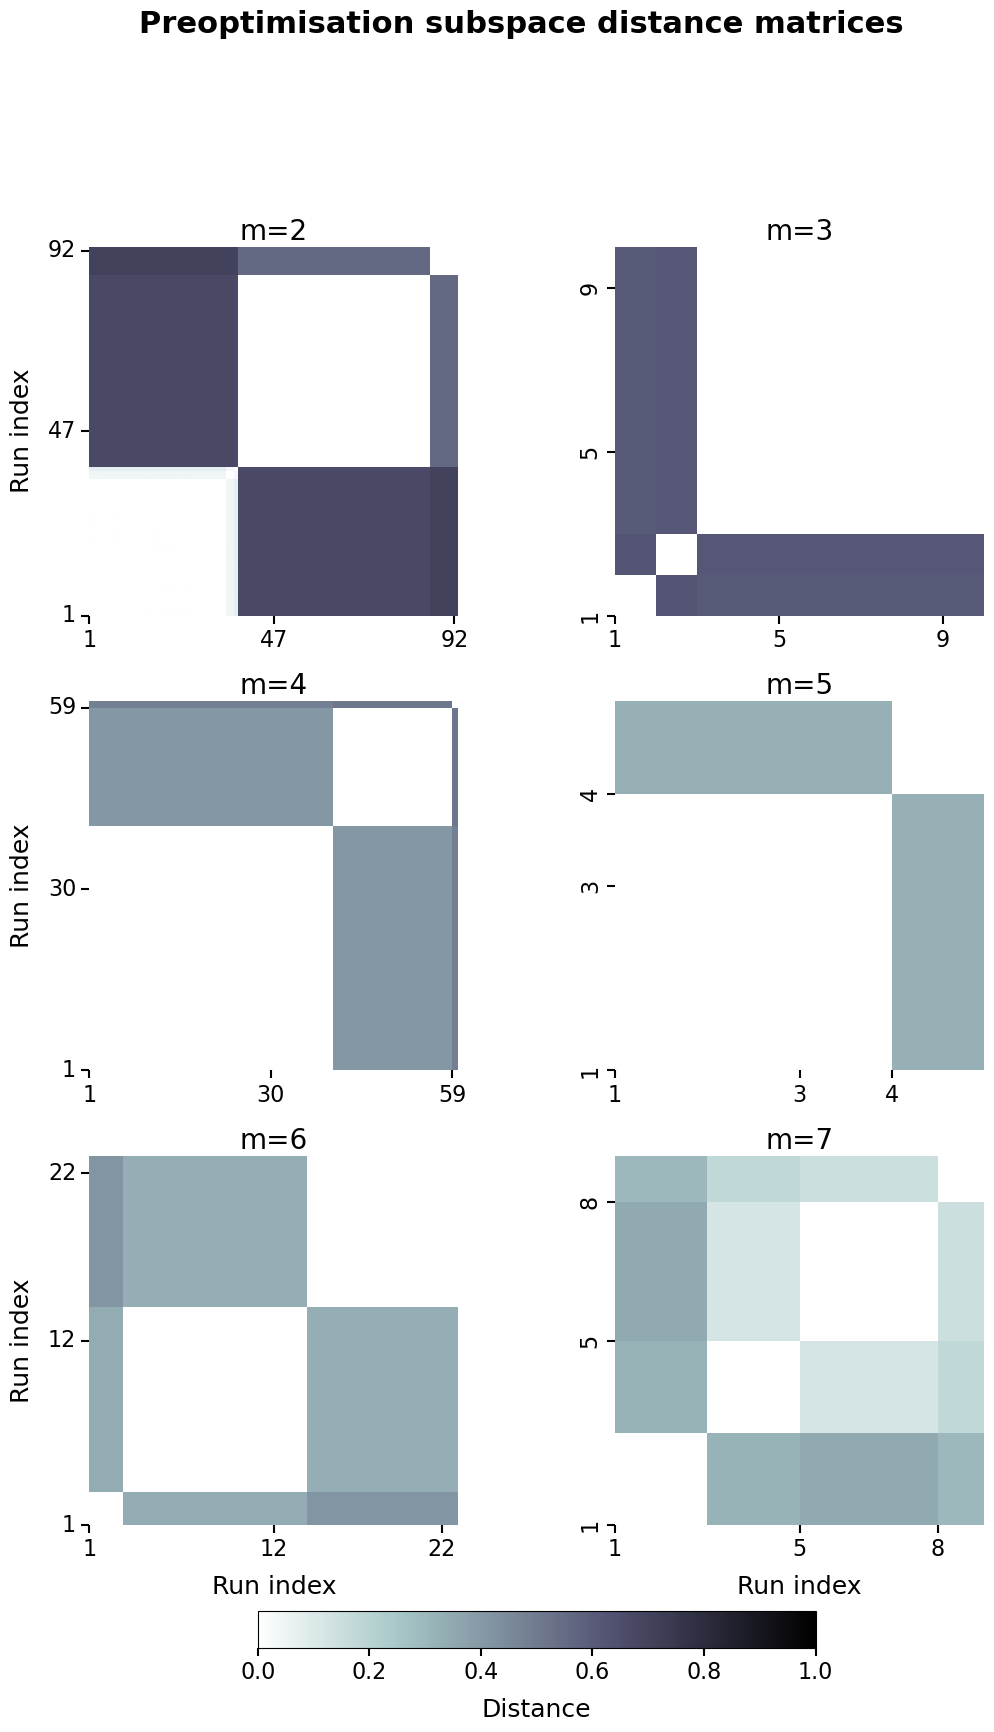

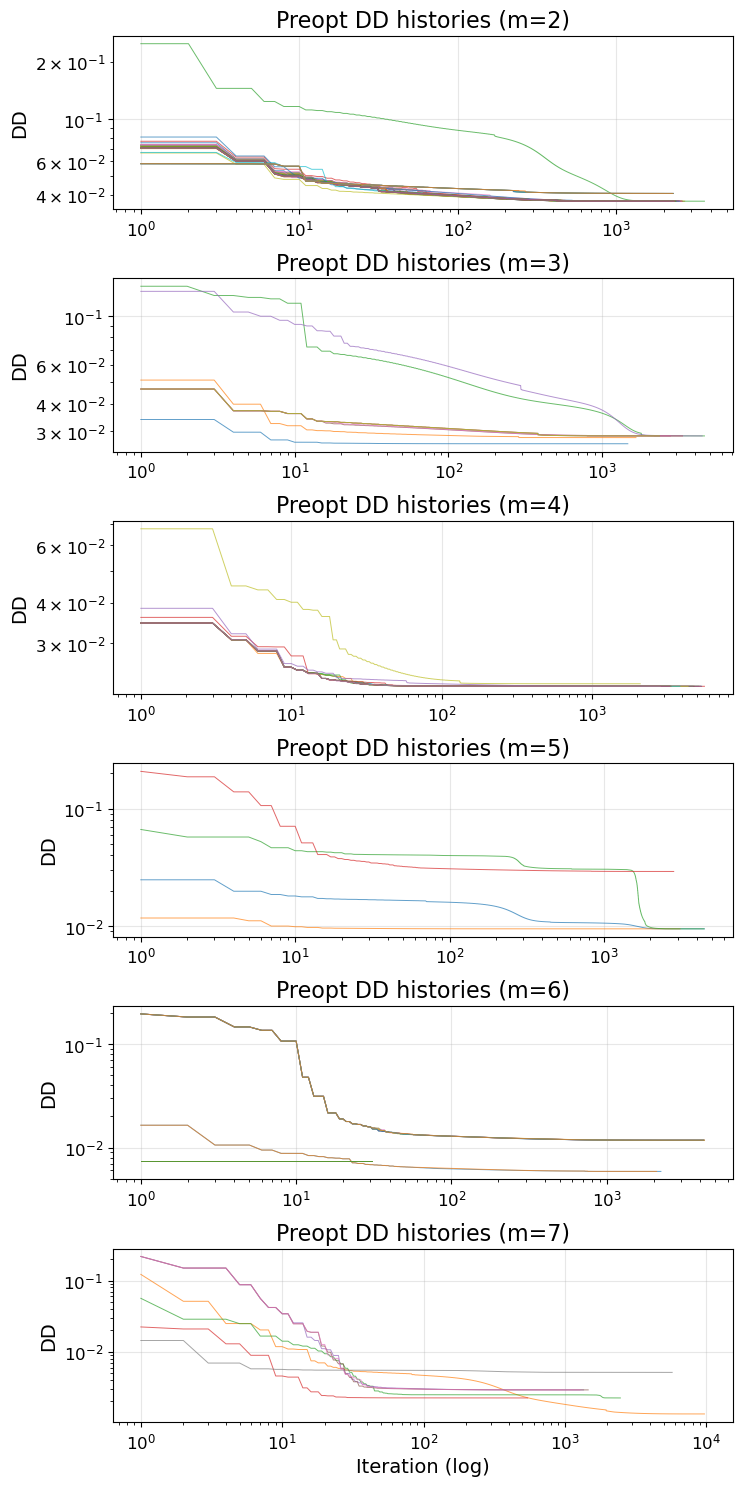

In [13]:
# Massage keys so the composite plotters understand them
opt_for_plot = {}
for m, res in opt_results.items():
    d = res.copy()
    d["goptp"] = d.pop("gopto")   # rename
    d["histp"] = d.pop("ohisto")
    opt_for_plot[f"m={m}"] = d

fig_g2 = plot_composite_goptp(opt_for_plot)
fig_g2.savefig(os.path.join(NB_OUT, "opt_goptp_all.png"), dpi=200)
fig_g2.show()

fig_h2 = plot_composite_histories(opt_for_plot)
fig_h2.savefig(os.path.join(NB_OUT, "opt_hist_all.png"), dpi=200)
fig_h2.show()



## 4  Save everything for later inspection


In [12]:
bundle = dict(
    model_path   = model_path,
    preopt_path  = preopt_path,
    optimisation = opt_results,
)
bundle_path = os.path.join(NB_OUT, "ssdi_demo_bundle.pkl")
with open(bundle_path, "wb") as f:
    pickle.dump(bundle, f)
print("Bundle saved ➜", bundle_path)

Bundle saved ➜ /Users/borjan/code/py_ssdi/nb_results/ssdi_demo_bundle.pkl
